# Assignment 2 - Stitching

_Tiffany Wang - 260684152_ 

In [10]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
# Load images.
hill1 = Image.open('./stitching_images/1Hill.JPG')
hill2 = Image.open('./stitching_images/2Hill.JPG')
hill3 = Image.open('./stitching_images/3Hill.JPG')

# Cast images to numpy arrays.
hill1 = np.array(hill1)
hill2 = np.array(hill2)
hill3 = np.array(hill3)

# Get image dimensions.
h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape
h3, w3, _ = hill3.shape

In [163]:
def Pyramid_Blending(A, B, depth=6):
    """
    Create pyramid blending function
    :param A: left image
    :param B: right image
    :param depth: depth of pyramid
    :return:
    """
    # generate Gaussian pyramid for A and B.
    GA, GB = A.copy(), B.copy()
    gpA, gpB = [GA], [GB]
    for i in range(depth):
        GA = cv2.pyrDown(GA)
        gpA.append(GA)

        GB = cv2.pyrDown(GB)
        gpB.append(GB)

    # generate Laplacian Pyramid for A and B.
    lpA, lpB = [gpA[depth-1]], [gpB[depth-1]]
    for i in range(depth-1,0,-1):
        hA, wA, _ = gpA[i-1].shape
        # Make sure that the destination size matches that of gpA[i-1].
        L = cv2.subtract(gpA[i-1],cv2.pyrUp(gpA[i], dstsize=(wA, hA)))
        lpA.append(L)

        hB, wB, _ = gpB[i-1].shape
        # Make sure that the destination size matches that of gpB[i-1].
        L = cv2.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=(wB, hB)))
        lpB.append(L)

    # Stack images together at each Laplacian Pyramid level.
    LS = []
    for la,lb in zip(lpA,lpB):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # Blend and reconstruct the final image.
    rs = LS[0]
    for i in range(1,depth):
        h, w, _ = LS[i].shape
        rs = cv2.pyrUp(rs, dstsize=(w, h))
        rs = cv2.add(rs, LS[i])
    
    return rs.astype(np.uint8)

In [142]:
def Linear_Blending(i_w, r_w, r_idx, s=0, e=1):
    """
    Create linear blending function
    :param i_w: image width
    :param r_w: ramp width
    :param r_idx: center ramp index
    :param s: starting ramp value
    :param e: ending ramp value
    :return:
    """
    res = np.zeros((i_w)).astype(np.float)
    step = (e - s) / (r_w - 1)
    
    # Start feathering out in incremental steps
    idx = r_idx - (r_w)
    for i in range(r_w):
        res[idx] = s + step * i
        idx += 1
    res[idx:] = 1
    return res

### Coding Questions 
#### PART I

#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.


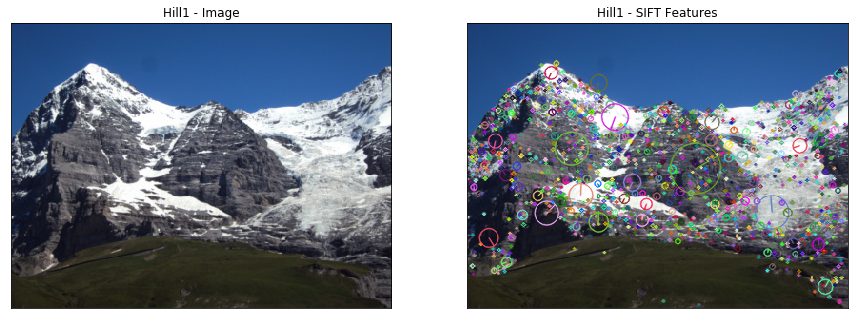

descriptors size: (1254, 128)


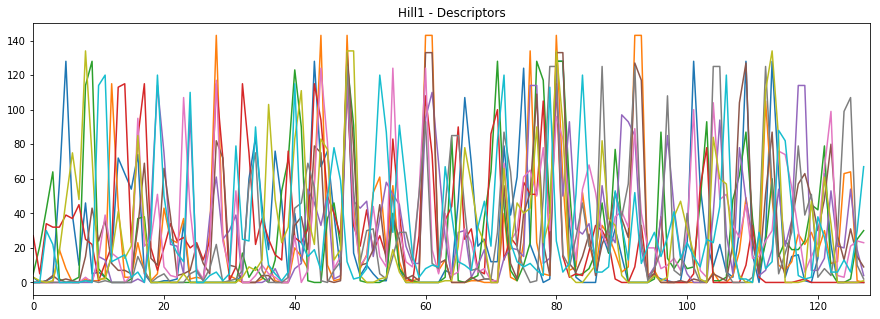

In [14]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 1Hill #
###############################################################

# copy of image 
hill1 = np.array(hill1)
hill1_c = hill1.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp1, des1 = sift.detectAndCompute(hill1, None)

# draw the keypoints
cv2.drawKeypoints(hill1, kp1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1)
plt.title("Hill1 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_c)
plt.title("Hill1 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT descriptors
print('descriptors size: '+ str(des1.shape))

num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill1 - Descriptors')
for i in range(num):
    plt.plot(des1[i])
    plt.xlim([0,128]) 
plt.show()

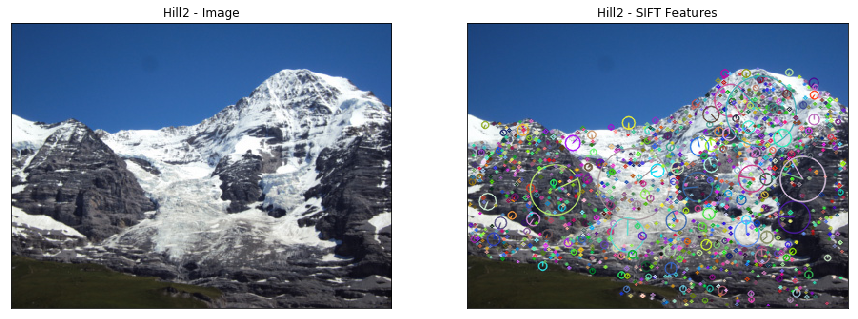

descriptors size: (1472, 128)


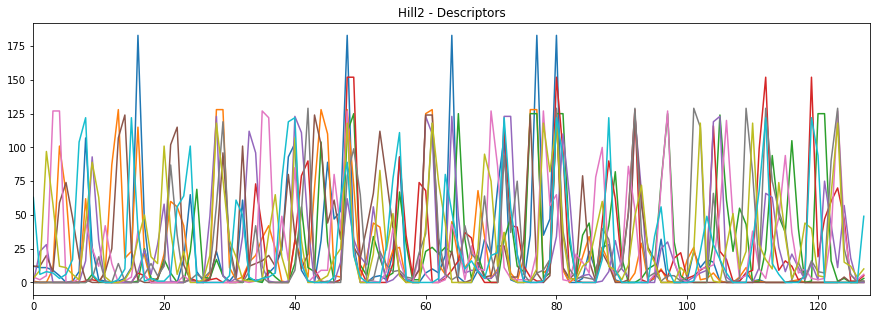

In [15]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 2Hill #
###############################################################

# copy of image 
hill2 = np.array(hill2)
hill2_c = hill2.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp2, des2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
cv2.drawKeypoints(hill2, kp2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill2)
plt.title("Hill2 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill2 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()


# num of SIFT descriptors
print('descriptors size: '+ str(des2.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill2 - Descriptors')
for i in range(num):
    plt.plot(des2[i])
    plt.xlim([0,128]) 
plt.show()

###### 2. Find matching keypoints in two images and display the 20 best pairs.

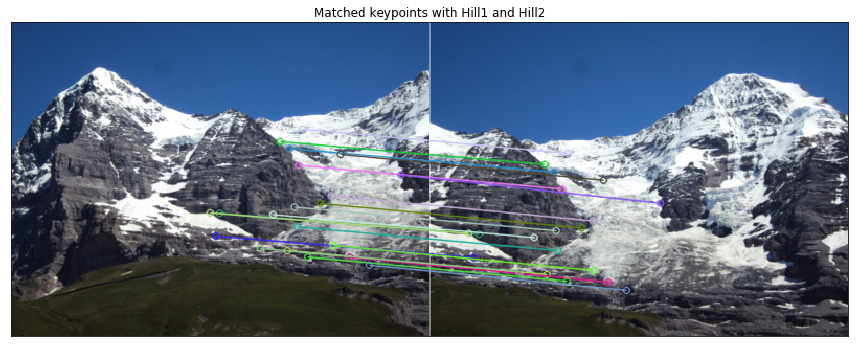

In [16]:
##############################################
# Matching Keypoints between 1Hill and 2Hill #
##############################################


# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill1,kp1, hill2, kp2, matches[:nb], hill1, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints with Hill1 and Hill2"), plt.xticks([]), plt.yticks([])
plt.show()

###### 3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

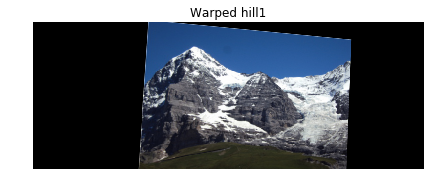

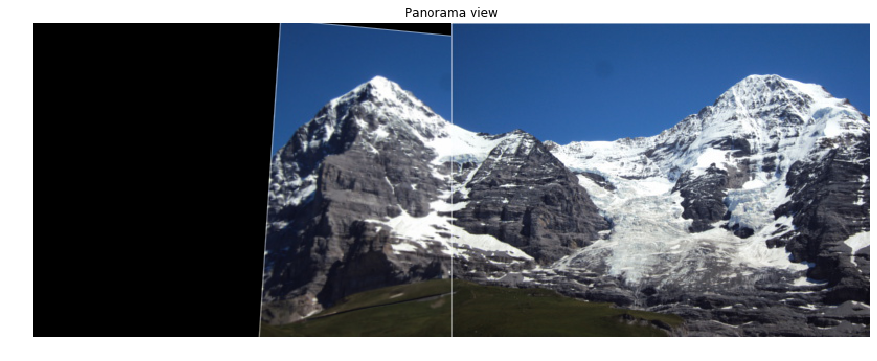

In [159]:
#####################################################
# Transform 1Hill to match the perspective of 2Hill #
#####################################################

matches_12 = []
for i, m in enumerate(matches):
    matches_12.append((m.trainIdx, m.queryIdx))
    
pts_r = np.float32([kp2[i].pt for (i, __) in matches_12])
pts_l = np.float32([kp1[i].pt for (__, i) in matches_12])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(pts_r)):
    pts_r[i][0] += hill2.shape[1]

M, _ = cv2.findHomography(pts_l, pts_r, cv2.RANSAC, 5)

# Use homography
warped = cv2.warpPerspective(hill1, M, (w1 + w2, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped)
plt.title("Warped hill1"), plt.axis('off')
plt.show()

glued = warped.copy()
glued[:, w2:,:] = hill2
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view"), plt.axis('off')
plt.show()

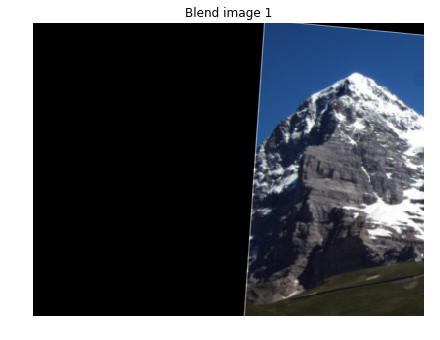

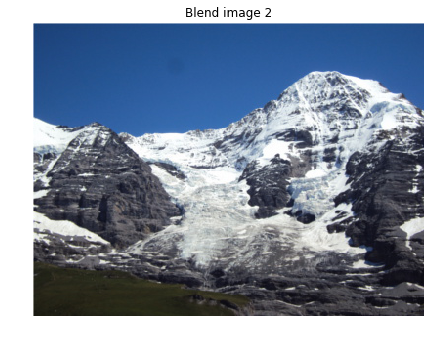

In [33]:
img1 = warped[:, :w1]
img2 = hill2

plt.figure(figsize=(7,7))
plt.imshow(img1)
plt.title("Blend image 1"), plt.axis('off')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(img2)
plt.title("Blend image 2"), plt.axis('off')
plt.show()

###### 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

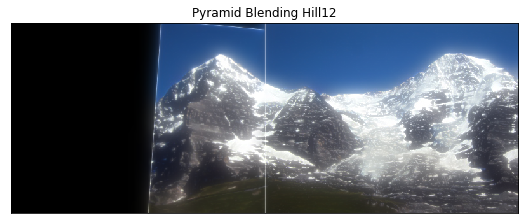

In [165]:
##########################
# Pyramid Image Blending #
##########################

hill12 = Pyramid_Blending(warped[:,:w1], hill2, 5)

# display results
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill12)
plt.title('Pyramid Blending Hill12'), plt.xticks([]), plt.yticks([])
plt.show()

In [35]:
h12, w12, _ = hill12.shape

#### PART II

###### 1. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

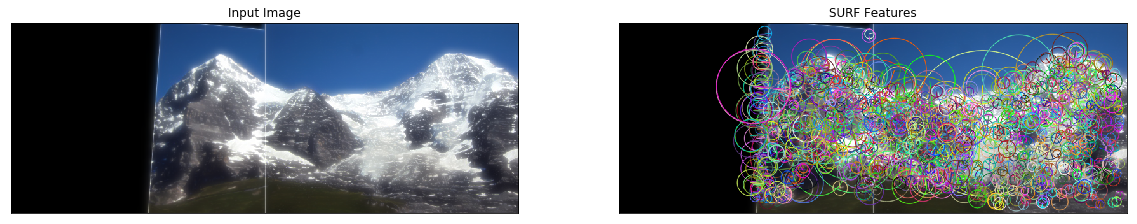

Num keypoints: 1161
descriptors size: (1161, 64)


In [152]:
################################################################
# Find SIFT keypoints and corresponding descriptors for 12Hill #
################################################################

# copy image
hill12_c = hill12.copy()
# convert to grayscale
hill12_grey = cv2.cvtColor(hill12, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
kp12, des12 = surf.detectAndCompute(hill12_grey, None)

# draw keypoints
cv2.drawKeypoints(hill12, kp12, hill12_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill12)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill12_c)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
print("Num keypoints: " + str(len(kp12)))

# num of SIFT descriptors
print('descriptors size: '+ str(des12.shape))


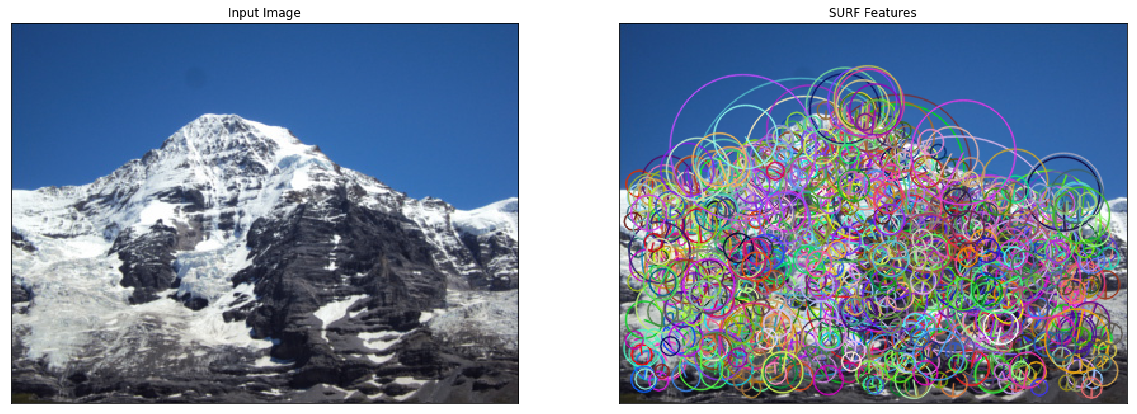

Num keypoints: 875
descriptors size: (875, 64)


In [153]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 3Hill #
###############################################################

# copy image
hill3_c = hill3.copy()
# convert to grayscale
hill3_grey = cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
kp3, des3 = surf.detectAndCompute(hill3_grey, None)

# draw keypoints
cv2.drawKeypoints(hill3, kp3, hill3_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill3)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill3_c)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
print("Num keypoints: " + str(len(kp3)))

# num of SIFT descriptors
print('descriptors size: '+ str(des3.shape))


###### 2. Find matching keypoints in two images and display the 20 best pairs.

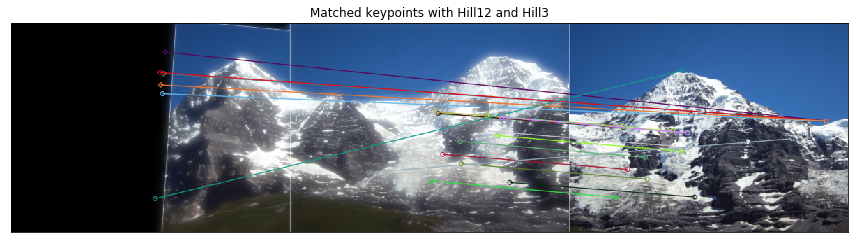

In [154]:
###############################################
# Matching Keypoints between 12Hill and 3Hill #
###############################################

bf = cv2.BFMatcher()
# Match descriptors.
matches_123 = bf.match(des12, des3)
# Sort them in the order of their distance.
matches_123 = sorted(matches_123, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill12, kp12, hill3, kp3, matches_123[:nb], hill12, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints with Hill12 and Hill3"), plt.xticks([]), plt.yticks([])
plt.show()



###### 3. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

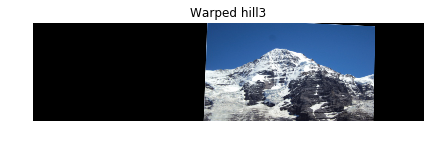

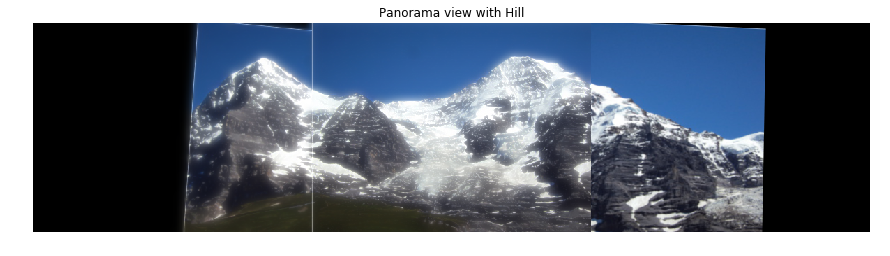

In [155]:
######################################################
# Transform 3Hill to match the perspective of 12Hill #
######################################################

# Match descriptors.
matches_312 = bf.match(des3, des12)
# Sort them in the order of their distance.
matches_312 = sorted(matches_312, key = lambda x:x.distance)

good_312 = []
for _, m in enumerate(matches_312):
    good_312.append((m.trainIdx, m.queryIdx))

# GoodMatches = GoodMatches[:-1]
pts_l = np.float32([kp12[i].pt for (i, __) in good_312])
pts_r = np.float32([kp3[i].pt for (__, i) in good_312])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(pts_r)):
    pts_r[i][0] += w12 + w3

M, _ = cv2.findHomography(pts_l, pts_r, cv2.RANSAC, 10)

# Use homography
warped3 = cv2.warpPerspective(hill3, M, (w1 + w2 + w3, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped3)
plt.title("Warped hill3"), plt.axis('off')
plt.show()

glued = warped3.copy()
glued[:, :w12,:] = hill12
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view with Hill"), plt.axis('off')
plt.show()

###### 4. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

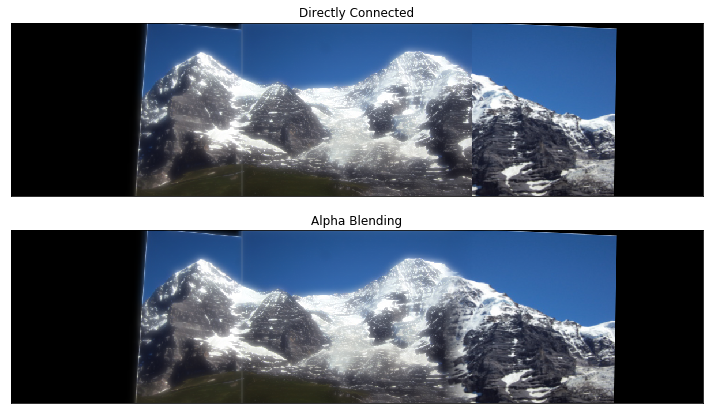

In [156]:
#########################
# Linear Image Blending #
#########################

# read images
img1 = np.zeros((h12, w12 + w3, 3)).astype(np.uint8)
img1[:,:w12,:] = hill12

img2 = warped3

# image with direct connecting each half
real = np.hstack((img1[:,:w12,:], img2[:,w12:,:])).astype(np.uint8)

# alpha blending ramp
ramp_size = 50
alpha = Linear_Blending(img1.shape[1], ramp_size, w12, s=0, e=1)

# Apply feathering to img1 and img2. And Blend.
I_blend = (1 - alpha.reshape(1,-1,1)) * img1 + alpha.reshape(1,-1,1) * img2
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,7))
plt.subplot(211), plt.imshow(real)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

### Reasoning Questions

###### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics.

SURF, as the name suggests, is faster than SIFT. Generally, SURF is 3-6 times faster than SIFT. This is because uses box filters of any size to approximate the integral operations. Whereas, in the cases of SIFT, the images are smoothes through multiple Gaussian sub sampling layers. SURF also only uses the Fast-Hessian matrix to find the locations and scale of interests instead of separating them into two different operations. However, this also makes it less robusts to changes compared to SIFT. This directly correlates with the higher density of keypoints SIFT detects compares to SURF. As seen in the previous examples, 1Hill and 2Hill have a total of 2726 SIFT features points, yet 12Hill only has 1161 keypoints. 

###### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?

<ul>
    <li><strong>Linear Blending</strong></li> 
    Pros: 
    <ul>
        <li> Easy to implement </li>
    </ul>
Cons: 
<ul>
    <li> Hard to balance between low frequency exposure variations and retaining sharp transitions </li> 
    <li> Does not work with all frequency ranges </li>
</ul>
    <li><strong>Pyramid Blending</strong></li> 
Pros: 
<ul>
    <li> Allows the images to blend at different frequency levels </li>
    <li> Removes ghost more efficiently </li>
</ul>

Cons: 
    <ul>
        <li> Computationally heavy </li> 
    </ul>
</ul>


In general, one should choose Pyramid blend when blending two pictures with low frequencies. 

###### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?

The perspective of the first image with respect to the second image may not be well computed. This leads to a bad perspective warping and bad stitching results. 

###### 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography.

A higher number of pairs of matching keypoints does not necessarily render a higher accuracy of the inferred homography. The importance is the strength of these matches. Too many weak (or bad) matches can bring in noise when inferring the homography of the image. It is thus important to find the good tradeoff. 